In [50]:
#instruction to be able to zoom on matplotlib figure
%matplotlib widget 


import sys
sys.path.insert(0,'../source')
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
#from datetime import datetime

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

# Import module for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, corr_data, copy_attr
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_corr_pres
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa
from m_read_write_netcdf import corr_file

In [51]:
#
# Init.
#

# WMO Float (string format)
num_float = '6902881'

cmp_ctd = 1 # 0 if no CTD comparaison, 1 otherwise
num_cycle = 2 # Cycle to compare to CTD
#rep_ctd = '/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/RREX/RREX17/'
#fic_ctd = 'rr17_PRES.nc' # Netcdf File with CTD
rep_ctd = '/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/'
fic_ctd = 'ovid18_PRES.nc'
num_ctd = 105 # Station Number to compare

# ARGO directory : Directory where you can find 1 directory per WMO ARGO float.
# In the WMO float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
#rep_data_argo = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/'
rep_data_argo = '/Volumes/ref-argo/gdac/dac/coriolis/'

# The WOA file containing the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# this file is created by an internal LOPS routine.
#
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'

# which variable to used :
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 2

#
# Which PSAT to used :
# which_psat = 1 : We use PSAT from WOA file
# which_psat = 2 We use PSAT calculated as Locodox
which_psat = 2
# Min and Max pressure to average WOA and ARGO PPOX
min_pres_interp = 0
max_pres_interp = 10

# Which QC used for pressure, temperature, salinity and oxygen.
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

In [52]:
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Volumes/ref-argo/gdac/dac/coriolis/6902881/6902881_meta.nc
/Volumes/ref-argo/gdac/dac/coriolis/6902881/6902881_Sprof.nc
/Volumes/ref-argo/gdac/dac/coriolis/6902881/6902881_Rtraj.nc


In [53]:
#ds_argo_Sprof = ds_argo_Sprof.where(ds_argo_Sprof['CYCLE_NUMBER']<107,drop=True)
#ds_argo_Sprof

In [54]:
fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
ds_bathy = xr.open_dataset(fic_bathy)

In [55]:
ds_argo_Sprof['PLATFORM_NUMBER'].values[0]

6902881

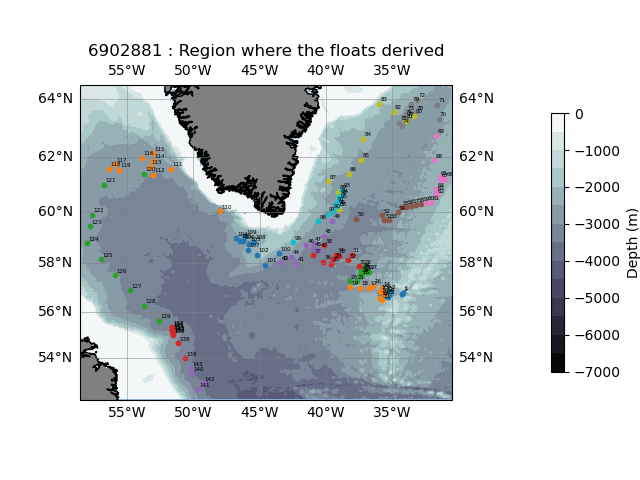

In [56]:
extend_lon_lat = 0.5
depths = np.arange(-7000,500,500)
plot_WMO_position(ds_argo_Sprof, ds_bathy, depths,extend_lon_lat)

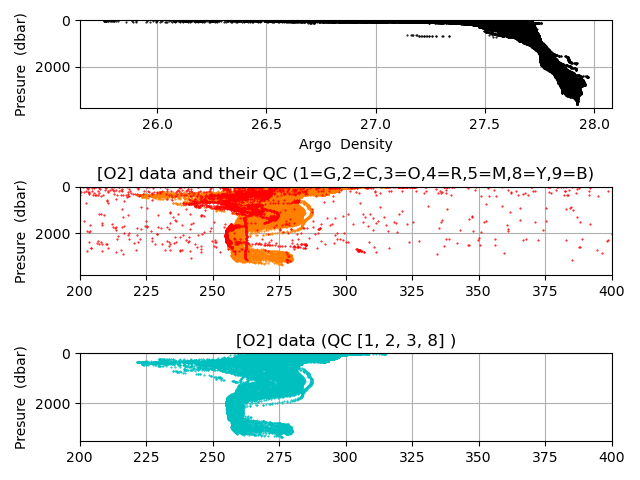

In [57]:
plot_DOXY_QC(ds_argo_Sprof,doxy_qc)

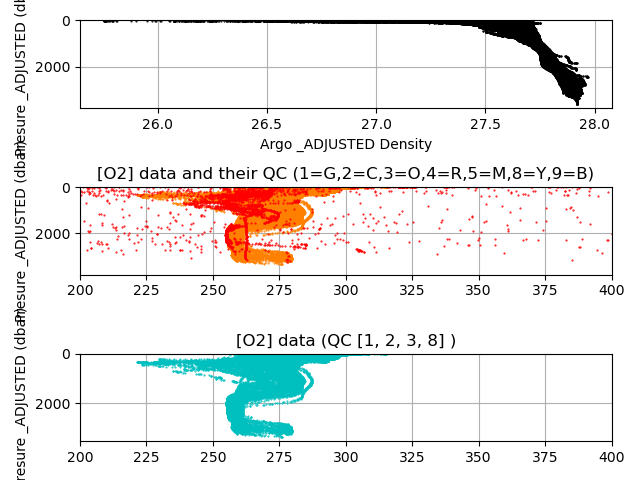

In [58]:
plot_DOXY_QC(ds_argo_Sprof,doxy_qc,'_ADJUSTED')

PRES
TEMP
PSAL


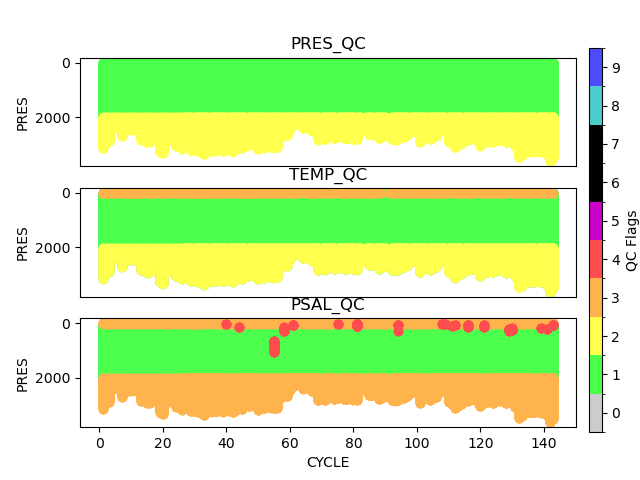

In [59]:
plot_QC_cycle(ds_argo_Sprof)

PRES_ADJUSTED
TEMP_ADJUSTED
PSAL_ADJUSTED


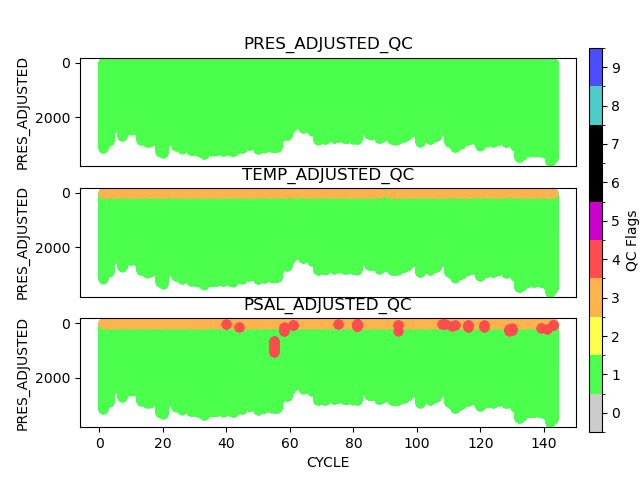

In [60]:
plot_QC_cycle(ds_argo_Sprof,'_ADJUSTED')

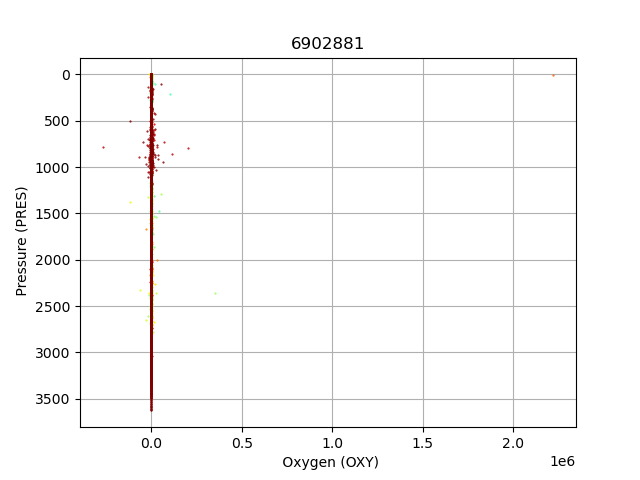

In [61]:
_=plot_DOXY_cycle(ds_argo_Sprof)

In [62]:
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)

2018-07-08T15:33:00.000000000
-0.3


In [63]:
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)

PSAL ADJUSTED Data Used
PRES ADJUSTED Data Used
TEMP ADJUSTED Data Used


In [64]:
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [65]:
ds_woa = open_WOA_file(fic_WOA)
ds_woa

We force Longitude in [-180 180]


<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, N_LEVELS: 102, time: 12)
Coordinates:
  * Depth      (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time       (time) float64 15.0 46.0 75.0 106.0 ... 259.0 289.0 320.0 350.0
Dimensions without coordinates: lat, lon, N_LEVELS
Data variables:
    latitude   (lat) float64 ...
    longitude  (lon) float64 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
    doxywoa    (time, N_LEVELS, lat, lon) float64 ...
    Psatwoa    (time, N_LEVELS, lat, lon) float64 ...
    density    (time, N_LEVELS, lat, lon) float64 ...
    preswoa    (time, N_LEVELS, lat, lon) float64 ...
    PSAL_WOA   (time, N_LEVELS, lat, lon) float64 ...
    TEMP_WOA   (time, N_LEVELS, lat, lon) float64 ...

In [66]:
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 -15.25 15.0 46.0 75.0 ... 289.0 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    density   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 nan nan nan nan ... nan nan nan
101.865898

In [67]:
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]

# Interpolation WOA et ARGO sur une grille reguliere en pression.
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [68]:
ds_argo_interp

<xarray.Dataset>
Dimensions:       (N_PROF: 144, N_LEVELS: 11)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    TEMP_ARGO     (N_PROF, N_LEVELS) float64 nan nan nan ... 4.414 4.414 4.415
    TEMP_ARGO_QC  (N_PROF, N_LEVELS) float64 nan nan nan ... 4.182 1.583 7.417
    PSAL_ARGO     (N_PROF, N_LEVELS) float64 nan nan nan ... 34.81 34.81 34.81
    PSAL_ARGO_QC  (N_PROF, N_LEVELS) float64 nan nan nan ... 4.182 1.583 7.417
    DOXY_ARGO     (N_PROF, N_LEVELS) float64 nan nan nan nan ... nan nan nan nan
    DOXY_ARGO_QC  (N_PROF, N_LEVELS) float64 nan nan nan ... 1.818 0.3333 3.667
    PRES_ARGO     (N_PROF, N_LEVELS) float64 nan nan nan nan ... 8.0 9.0 10.0
    PRES_ARGO_QC  (N_PROF, N_LEVELS) float64 nan nan nan nan ... 1.0 1.0 1.0 1.0

In [69]:
# Faire fonction copy attributs
#for var in var_to_interpol:
#    ds_argo_interp[var].attrs = ds_argo[var].attrs
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [70]:
ds_woa_interp

<xarray.Dataset>
Dimensions:   (N_PROF: 144, N_LEVELS: 11)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    doxywoa   (N_PROF, N_LEVELS) float64 299.4 299.5 299.5 ... 344.7 344.2 343.8
    Psatwoa   (N_PROF, N_LEVELS) float64 105.9 105.9 105.9 ... 106.3 106.3 106.3
    density   (N_PROF, N_LEVELS) float64 1.027e+03 1.027e+03 ... 1.027e+03
    preswoa   (N_PROF, N_LEVELS) float64 0.0 1.0 2.0 3.0 ... 7.0 8.0 9.0 10.0
    PSAL_WOA  (N_PROF, N_LEVELS) float64 34.82 34.83 34.83 ... 34.02 34.03 34.04
    TEMP_WOA  (N_PROF, N_LEVELS) float64 9.024 9.01 8.995 ... 3.791 3.776 3.761

In [71]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

We calculate PSAT as Locodox Matlab does


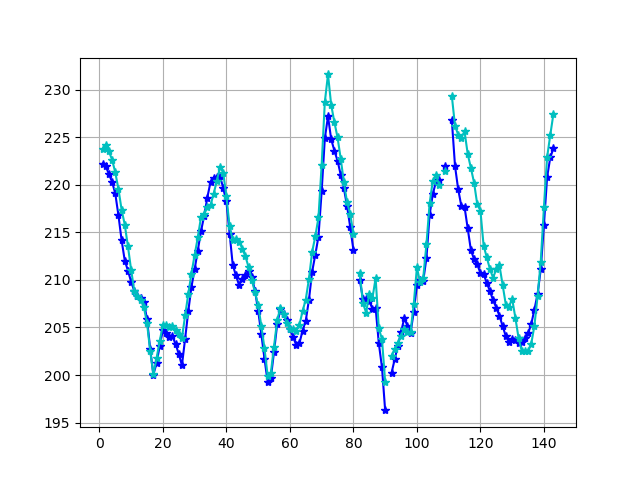

In [72]:
if which_psat == 2:
    print('We calculate PSAT as Locodox Matlab does')
    ana_dens_woa = sw.pden(ds_woa_interp['PSAL_WOA'],ds_woa_interp['TEMP_WOA'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
    O2_ARGO_umolL = umolkg_to_umolL(ds_woa_interp['doxywoa'],ds_argo['DOXY_ARGO'].units,ana_dens_woa)
    psatwoaV2 = O2ctoO2s(O2_ARGO_umolL,ds_woa_interp['TEMP_WOA'],ds_woa_interp['PSAL_WOA'])
    ppox_WOA2 = O2stoO2p(psatwoaV2,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
    ppox_WOA_mean2 = np.nanmean(ppox_WOA2,axis=1)

    plt.figure()
    plt.plot(ppox_WOA_mean,'*-b')
    plt.plot(ppox_WOA_mean2,'*-c')
    plt.grid()

    ppox_WOA_mean = ppox_WOA_mean2

In [73]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [74]:
# Correction : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
#params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean, ppox_WOA_mean, p0=initial_guess,nan_policy='omit')
#print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)

initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')


In [75]:
# Correction : Gain and Drift Time estimation

initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)

In [76]:
print(params_Gain_Derive_WOA)

[1.03913101 1.4471664 ]


In [77]:
print(params_Gain_WOA)
print(params_Gain_Derive_WOA)

[1.05214715]
[1.03913101 1.4471664 ]


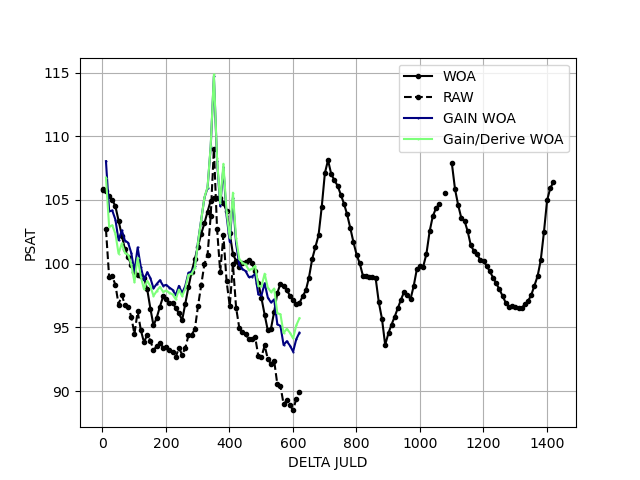

In [78]:
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain/Derive WOA' : params_Gain_Derive_WOA}
_=plot_cmp_corr_WOA(dict_corr, ds_argo_interp, ds_woa_interp, delta_T_WOA)

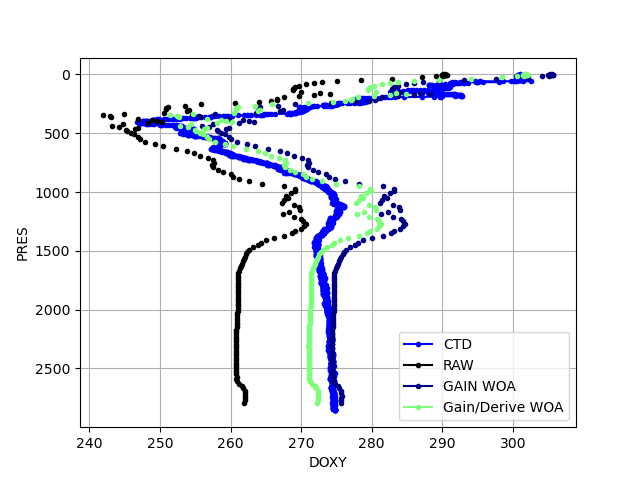

In [79]:
# Compare ARGO Profil  with  CTD 
if cmp_ctd == 1:
    ds_cruise = xr.open_dataset(rep_ctd + fic_ctd)
    ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd,drop=True)
    ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
    _=plot_cmp_ARGO_CTD(ds_cruise, ds_argo_Sprof,ds_cycle, dict_corr, launch_date) 

In [80]:
# Which corrrection to apply
params_to_keep = params_Gain_Derive_WOA
    
print(params_to_keep)

# Comparison between CTD and ARGO float Cycle
if cmp_ctd==1:
    oxy_ctd_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))


    delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
    tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))


    # Correction for the cycle associated to the CTD
    cycle_corr = model_Gain_Derive([ds_cycle['DOXY'].isel(N_PROF=0).values,tab_delta_T],*params_to_keep)


    if num_float == str(6902881):
        print('pressure effect')
        pressure_threshold = 1500  
        PRES_1D = ds_cycle.PRES.squeeze()  

        mask = PRES_1D >= pressure_threshold
        ds_filtered = ds_cycle.sel(N_LEVELS=mask)
        oxy_filtered = oxy_ctd_interp[0][mask.values]   
        cycle_corr_pour_pres = cycle_corr[0][mask.values] 
    
        initial_guess = [0]   
        params_Gain_Pression, covariance = curve_fit(model_corr_pres, [cycle_corr_pour_pres,ds_filtered['PRES'].isel(N_PROF=0).values], oxy_filtered, p0=initial_guess,nan_policy='omit')
    
        print(params_Gain_Pression)
    #cycle_corr  = (1 + params_Gain_Pression[0]*ds_cycle['PRES'][0].values/1000) * cycle_corr # Corr effet de pression
        cycle_corr = model_corr_pres([cycle_corr,ds_cycle['PRES'].isel(N_PROF=0).values],*params_Gain_Pression)
    else:
        print('No pressure effect correction')
        params_Gain_Pression = np.array([0])
else:
    params_Gain_Pression = np.array([0])

print(params_Gain_Pression[0])

[1.03913101 1.4471664 ]
pressure effect
[0.00398572]
0.003985717935943537


In [81]:
# Gain from CTD
if cmp_ctd==1:
    initial_guess = 0
    params_Gain_CTD, covariance = curve_fit(model_Gain, cycle_corr[0], oxy_ctd_interp[0], p0=initial_guess,nan_policy='omit')
else:
    params_Gain_CTD = np.array([1])
#cycle1_corr2 = cycle1_corr * params_Gain_CTD
print(params_Gain_CTD)

[0.99892888]


In [82]:
derive_final = 0
gain_final = params_Gain_CTD[0] * params_to_keep[0]

if len(params_to_keep)==2:
    derive_final = params_to_keep[1]
corr_final = np.array([gain_final,derive_final,params_Gain_Pression[0]])
print(corr_final)

[1.03801797 1.4471664  0.00398572]


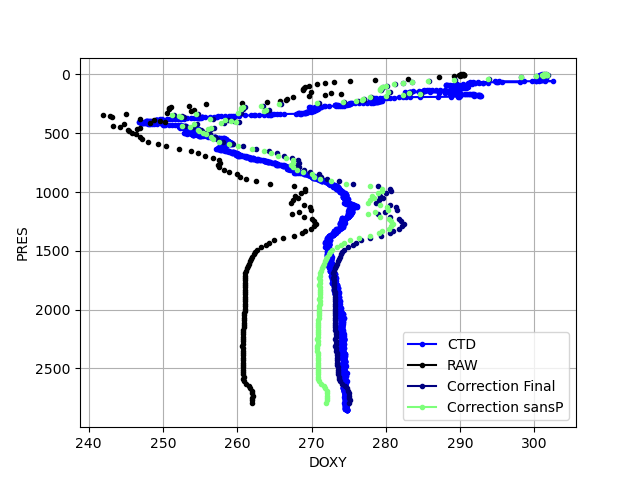

In [83]:
if cmp_ctd==1:
    dict_corr = {'Correction Final' : corr_final,'Correction sansP' : np.array([gain_final,derive_final])}
    _=plot_cmp_ARGO_CTD(ds_cruise, ds_argo_Sprof,ds_cycle, dict_corr, launch_date) 

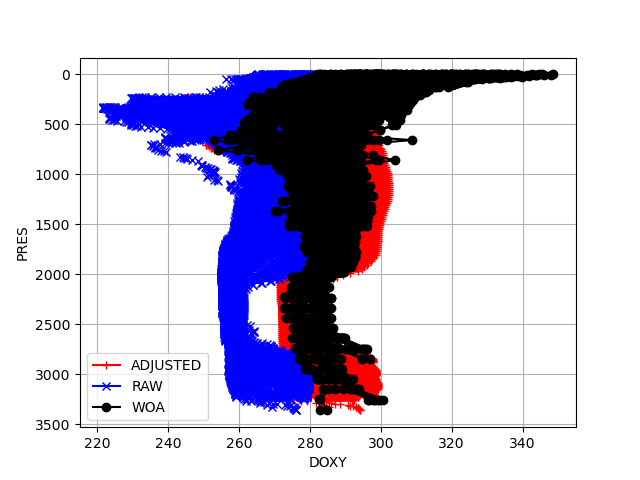

In [84]:
ds_argo_Sprof = corr_data(ds_argo_Sprof,corr_final,launch_date)
_=plot_cmp_corr_oxy_woa(ds_argo_Sprof, ds_woa_interp_on_ARGO)

In [85]:
ds_argo_final = ds_argo_Sprof[['DOXY_ADJUSTED','CYCLE_NUMBER','PRES']]
ds_argo_final.to_netcdf('/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test/corr_python_' + str(ds_argo_Sprof['PLATFORM_NUMBER'].values[0]) + '.nc')

In [34]:
#
# Gain et Derive final.
#
#gain_final = params_Gain_CTD[0] * params_Gain_Derive_NCEP[0]
#derive_final = params_Gain_Derive_NCEP[1]
coef_pres = params_Gain_Pression[0]
val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
comment_corr = 'Adjustement made with NCEP for Gain/Drift + Gain with CTD OVIDE2018 81'
coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, OFFSET=0.000000, DRIFT2=0.000000'
eq_corr = 'PPOX_DOXY = f(DOXY1); PPOX_DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365+DRIFT2/100.*(profile_date_juld-launch_date_juld)**2/365**2)+INCLINE_T*TEMP)*PPOX_DOXY; DOXY_ADJUSTED=f(PPOX_DOXY_ADJUSTED)'
for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_res,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    #print(fic_en_cours)
    #print(fic_res)
    if os.path.exists(fic_res):
        os.remove(fic_res)
    corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,gain_final,derive_final,coef_pres)

In [84]:
derive_final

0.49142905130333747